#### EMACS LISP STUFF PLEASE IGNORE
(defun switch-to-notebook ()
 (interactive)
 (st-toggle-to-buffer "*ein: http://127.0.0.1:8899/make_figs.ipynb*"))

In [1]:
%pylab inline
import os,sys
from importlib import reload
from copy import deepcopy
plt.style.use("default")
plt.rcParams["figure.figsize"] = (8,3)
from matplotlib.gridspec import GridSpec
from scipy.signal import stft
from builtins import sum as bsum

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Don't reload this, otherwise it will create a new units registry object
# and will then complain about combining different registries.
import units; UNITS = units.UNITS

In [25]:
flush = lambda *args, **kwargs: [sys.stdout.flush(), print(*args, **kwargs)]

In [3]:
import boulder;   reload(boulder)
import crick;     reload(crick)
import surrogate; reload(surrogate)
import fisher_plumes_tools as fpt;      reload(fpt)
import fisher_plumes_figs  as fpf;      reload(fpf);
import fisher_plumes_fig_tools as fpft; reload(fpft)
import fisher_plumes as fp;             reload(fp)
import utils; reload(utils)
FisherPlumes = fp.FisherPlumes

n_bootstraps = 50
pairs_mode = "unsigned"

crick.logger.setLevel(logging.DEBUG)
force_reload = False

if force_reload or ('Fbw' not in locals()):
    Fbw = FisherPlumes("boulder16", pitch = 25000 * UNITS.um,  freq_max = 20 * UNITS.hertz,
                       which_coords = [(0.45, 0.5),
                                       #(0.35,0.5),
                                       #(0.25,0.5),
                                       #(0.15,0.5)
                                       ]*UNITS.m,
                       py_mode = "relative",
                       suffix  = "manuscript",
                       pairs_mode = pairs_mode, n_bootstraps = n_bootstraps, random_seed = 0)
else:
    Fbw = FisherPlumes(Fbw)
    Fbw.n_bootstraps = n_bootstraps
    
if force_reload or ('Fcr' not in locals()):
    Fcr = FisherPlumes("n12dishT",  pitch = 76000 * UNITS.um, freq_max = 100 * UNITS.hertz,
                       which_coords = [(1.0, 0.5),
                                       #(0.9,0.5),
#                                       (0.7,0.5),
                                       #(0.6,0.5)
                                       ]*UNITS.m,
                       pairs_mode = pairs_mode, n_bootstraps = n_bootstraps, random_seed = 0)
else:
    Fcr = FisherPlumes(Fcr)
    Fcr.n_bootstraps = n_bootstraps

if force_reload or ('Fsu' not in locals()):
    Fsu = FisherPlumes("surr_all_equal",
                       freq_max     = 100 * UNITS.hertz,
                       pitch        = 0.025 * UNITS.m,
                       which_coords = [(1.0, 0.)]*UNITS.m,
                       n_sources    = 16,
                       pairs_mode   = pairs_mode, n_bootstraps = n_bootstraps, random_seed = 1)    
else:
    Fsu = FisherPlumes(Fsu)
    Fsu.n_bootstraps = n_bootstraps

data = {
    "cr":Fcr,
    "bw":Fbw,
    "su":Fsu
}

INFO:boulder:Boulder simulation data available for:


INFO:boulder:Re100_0_5mm_50Hz_16source_manuscript.h5         : ['Odor Data/c1a', 'Odor Data/c1b', 'Odor Data/c2a', 'Odor Data/c2b', 'Odor Data/c3a', 'Odor Data/c3b', 'Odor Data/c4a', 'Odor Data/c4b', 'Odor Data/c5a', 'Odor Data/c5b', 'Odor Data/c6a', 'Odor Data/c6b', 'Odor Data/c7a', 'Odor Data/c7b', 'Odor Data/c8a', 'Odor Data/c8b'] (16 datasets)


INFO:boulder:Boulder simulation data available for:


INFO:boulder:Re100_0_5mm_50Hz_16source_manuscript.h5         : ['Odor Data/c1a', 'Odor Data/c1b', 'Odor Data/c2a', 'Odor Data/c2b', 'Odor Data/c3a', 'Odor Data/c3b', 'Odor Data/c4a', 'Odor Data/c4b', 'Odor Data/c5a', 'Odor Data/c5b', 'Odor Data/c6a', 'Odor Data/c6b', 'Odor Data/c7a', 'Odor Data/c7b', 'Odor Data/c8a', 'Odor Data/c8b'] (16 datasets)


INFO:crick:Simulation data available for:


INFO:crick:ff_int_sym_slow_high_tres_wide_n12dishT         : Y0.450 - Y0.550 (11 datasets)


INFO:crick:Simulation data available for:


INFO:crick:ff_int_sym_slow_high_tres_wide_n12dishT         : Y0.450 - Y0.550 (11 datasets)


INFO:surrogate:Surrogate simulation data available for: ['no_info', 'one_info', 'two_info', 'spike_and_slab', 'blue', 'red', 'all_equal']


INFO:surrogate:Surrogate simulation data available for: ['no_info', 'one_info', 'two_info', 'spike_and_slab', 'blue', 'red', 'all_equal']


           fisher_plumes 2023/05/16 07:42:25     INFO: ****** LOADING sim_name='boulder16' ******


           fisher_plumes 2023/05/16 07:42:25     INFO: 1 boulder16_pitch = 0.024999999999999998 m


           fisher_plumes 2023/05/16 07:42:25     INFO: 1 boulder16_pitch = 2.5 cm


           fisher_plumes 2023/05/16 07:42:25     INFO: 1 boulder16_pitch = 24.999999999999996 mm


           fisher_plumes 2023/05/16 07:42:25     INFO: 1 boulder16_pitch = 24999.999999999996 µm


     fisher_plumes_tools 2023/05/16 07:42:25     INFO: Using relative py coordinates.


INFO:boulder:Loading data from file_name='Re100_0_5mm_50Hz_16source_manuscript.h5'.


INFO:boulder:
Re100_0_5mm_50Hz_16source_manuscript.h5 <BoulderSimulationData>
x_lim: 0 meter to 0.5 meter
y_lim: -0.21125 meter to 0.21125 meter
x-y Dimensions: [0.5 0.4225] m
x-range: 0.000 meter, 0.001 meter ... 0.500 meter (1001 points)
y-range: 0.211 meter, 0.211 meter ... -0.211 meter (846 points)
t-range: 0.000 second, 0.020 second ... 60.000 second (3001 points)
fs: 50 hertz
Sources:
  0: =    c1a @ (x = +0 meter, y = +0.00375 meter)
  1: =    c1b @ (x = +0 meter, y = -0.00375 meter)
  2: =    c2a @ (x = +0 meter, y = +0.01125 meter)
  3: =    c2b @ (x = +0 meter, y = -0.01125 meter)
  4: =    c3a @ (x = +0 meter, y = +0.01875 meter)
  5: =    c3b @ (x = +0 meter, y = -0.01875 meter)
  6: =    c4a @ (x = +0 meter, y = +0.02625 meter)
  7: =    c4b @ (x = +0 meter, y = -0.02625 meter)
  8: =    c5a @ (x = +0 meter, y = +0.03375 meter)
  9: =    c5b @ (x = +0 meter, y = -0.03375 meter)
 10: =    c6a @ (x = +0 meter, y = +0.04125 meter)
 11: =    c6b @ (x = +0 meter, y = -0.04125 m

INFO:boulder:Mapped coordinate (0.450 meter, 0.000 meter) to (0.450 meter, 0.000 meter), index (900, 422), name 'x=18 ϕ'.


INFO:boulder:Field c1a has shape (3001, 1).


INFO:boulder:Field c1b has shape (3001, 1).


INFO:boulder:Field c2a has shape (3001, 1).


INFO:boulder:Field c2b has shape (3001, 1).


INFO:boulder:Field c3a has shape (3001, 1).


INFO:boulder:Field c3b has shape (3001, 1).


INFO:boulder:Field c4a has shape (3001, 1).


INFO:boulder:Field c4b has shape (3001, 1).


INFO:boulder:Field c5a has shape (3001, 1).


INFO:boulder:Field c5b has shape (3001, 1).


INFO:boulder:Field c6a has shape (3001, 1).


INFO:boulder:Field c6b has shape (3001, 1).


INFO:boulder:Field c7a has shape (3001, 1).


INFO:boulder:Field c7b has shape (3001, 1).


INFO:boulder:Field c8a has shape (3001, 1).


INFO:boulder:Field c8b has shape (3001, 1).


     fisher_plumes_tools 2023/05/16 07:44:01     INFO: Computing pairs for len(yvals)=16 from -56250 to 56250 using pairs_mode='unsigned'.


     fisher_plumes_tools 2023/05/16 07:44:01     INFO: Removing duplicates in pairs dictionary.


           fisher_plumes 2023/05/16 07:44:01     INFO: ****** LOADING sim_name='n12dishT' ******


           fisher_plumes 2023/05/16 07:44:01     INFO: 1 n12dishT_pitch = 0.076 m


           fisher_plumes 2023/05/16 07:44:01     INFO: 1 n12dishT_pitch = 7.6 cm


           fisher_plumes 2023/05/16 07:44:01     INFO: 1 n12dishT_pitch = 76.0 mm


           fisher_plumes 2023/05/16 07:44:01     INFO: 1 n12dishT_pitch = 76000.0 µm


INFO:crick:load_sims for sim_name='n12dishT' with which_coords=<Quantity([[1.  0.5]], 'meter')> (py_mode='absolute').


     fisher_plumes_tools 2023/05/16 07:44:01     INFO: Using absolute py coordinates.


DEBUG:crick:x: 0.2 - 1.1993749999999999


DEBUG:crick:y: 0.0005540315 - 0.9994492500000001


DEBUG:crick:t: 0.001 - 150.0


DEBUG:crick:probe_data: (150000, 1681)


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.550 with data at 1681 locations.


INFO:crick:1 ϕ = 0.076 m


DEBUG:crick:(nx,ny,nz) = (41,41,1)


DEBUG:crick:x-range: 0.2 meter - 1.2 meter


DEBUG:crick:y-range: 0.000554 meter - 0.999 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Mapped coordinate (1.000 meter, 0.500 meter) to (0.999 meter, 0.500 meter), index 852, name x=7.9 ϕ, y=-0.7 ϕ.


DEBUG:crick:x: 0.2 - 1.1993749999999999


DEBUG:crick:y: 0.0005540315 - 0.9994492500000001


DEBUG:crick:t: 0.001 - 150.0


DEBUG:crick:probe_data: (150000, 1681)


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.500 with data at 1681 locations.


INFO:crick:1 ϕ = 0.076 m


DEBUG:crick:(nx,ny,nz) = (41,41,1)


DEBUG:crick:x-range: 0.2 meter - 1.2 meter


DEBUG:crick:y-range: 0.000554 meter - 0.999 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Mapped coordinate (1.000 meter, 0.500 meter) to (0.999 meter, 0.500 meter), index 852, name x=7.9 ϕ.


DEBUG:crick:x: 0.2 - 1.1993749999999999


DEBUG:crick:y: 0.0005540315 - 0.9994492500000001


DEBUG:crick:t: 0.001 - 150.0


DEBUG:crick:probe_data: (150000, 1681)


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.450 with data at 1681 locations.


INFO:crick:1 ϕ = 0.076 m


DEBUG:crick:(nx,ny,nz) = (41,41,1)


DEBUG:crick:x-range: 0.2 meter - 1.2 meter


DEBUG:crick:y-range: 0.000554 meter - 0.999 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Mapped coordinate (1.000 meter, 0.500 meter) to (0.999 meter, 0.500 meter), index 852, name x=7.9 ϕ, y=0.7 ϕ.


DEBUG:crick:x: 0.2 - 1.1993749999999999


DEBUG:crick:y: 0.0005540315 - 0.9994492500000001


DEBUG:crick:t: 0.001 - 150.0


DEBUG:crick:probe_data: (150000, 1681)


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.520 with data at 1681 locations.


INFO:crick:1 ϕ = 0.076 m


DEBUG:crick:(nx,ny,nz) = (41,41,1)


DEBUG:crick:x-range: 0.2 meter - 1.2 meter


DEBUG:crick:y-range: 0.000554 meter - 0.999 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Mapped coordinate (1.000 meter, 0.500 meter) to (0.999 meter, 0.500 meter), index 852, name x=7.9 ϕ, y=-0.3 ϕ.


DEBUG:crick:x: 0.2 - 1.1993749999999999


DEBUG:crick:y: 0.0005540315 - 0.9994492500000001


DEBUG:crick:t: 0.001 - 150.0


DEBUG:crick:probe_data: (150000, 1681)


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.480 with data at 1681 locations.


INFO:crick:1 ϕ = 0.076 m


DEBUG:crick:(nx,ny,nz) = (41,41,1)


DEBUG:crick:x-range: 0.2 meter - 1.2 meter


DEBUG:crick:y-range: 0.000554 meter - 0.999 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Mapped coordinate (1.000 meter, 0.500 meter) to (0.999 meter, 0.500 meter), index 852, name x=7.9 ϕ, y=0.3 ϕ.


DEBUG:crick:x: 0.2 - 1.1993749999999999


DEBUG:crick:y: 0.0005540315 - 0.9994492500000001


DEBUG:crick:t: 0.001 - 150.0


DEBUG:crick:probe_data: (150000, 1681)


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.510 with data at 1681 locations.


INFO:crick:1 ϕ = 0.076 m


DEBUG:crick:(nx,ny,nz) = (41,41,1)


DEBUG:crick:x-range: 0.2 meter - 1.2 meter


DEBUG:crick:y-range: 0.000554 meter - 0.999 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Mapped coordinate (1.000 meter, 0.500 meter) to (0.999 meter, 0.500 meter), index 852, name x=7.9 ϕ, y=-0.1 ϕ.


DEBUG:crick:x: 0.2 - 1.1993749999999999


DEBUG:crick:y: 0.0005540315 - 0.9994492500000001


DEBUG:crick:t: 0.001 - 150.0


DEBUG:crick:probe_data: (150000, 1681)


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.498 with data at 1681 locations.


INFO:crick:1 ϕ = 0.076 m


DEBUG:crick:(nx,ny,nz) = (41,41,1)


DEBUG:crick:x-range: 0.2 meter - 1.2 meter


DEBUG:crick:y-range: 0.000554 meter - 0.999 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Mapped coordinate (1.000 meter, 0.500 meter) to (0.999 meter, 0.500 meter), index 852, name x=7.9 ϕ.


DEBUG:crick:x: 0.2 - 1.1993749999999999


DEBUG:crick:y: 0.0005540315 - 0.9994492500000001


DEBUG:crick:t: 0.001 - 150.0


DEBUG:crick:probe_data: (150000, 1681)


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.502 with data at 1681 locations.


INFO:crick:1 ϕ = 0.076 m


DEBUG:crick:(nx,ny,nz) = (41,41,1)


DEBUG:crick:x-range: 0.2 meter - 1.2 meter


DEBUG:crick:y-range: 0.000554 meter - 0.999 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Mapped coordinate (1.000 meter, 0.500 meter) to (0.999 meter, 0.500 meter), index 852, name x=7.9 ϕ.


DEBUG:crick:x: 0.2 - 1.1993749999999999


DEBUG:crick:y: 0.0005540315 - 0.9994492500000001


DEBUG:crick:t: 0.001 - 150.0


DEBUG:crick:probe_data: (150000, 1681)


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.495 with data at 1681 locations.


INFO:crick:1 ϕ = 0.076 m


DEBUG:crick:(nx,ny,nz) = (41,41,1)


DEBUG:crick:x-range: 0.2 meter - 1.2 meter


DEBUG:crick:y-range: 0.000554 meter - 0.999 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Mapped coordinate (1.000 meter, 0.500 meter) to (0.999 meter, 0.500 meter), index 852, name x=7.9 ϕ, y=0.1 ϕ.


DEBUG:crick:x: 0.2 - 1.1993749999999999


DEBUG:crick:y: 0.0005540315 - 0.9994492500000001


DEBUG:crick:t: 0.001 - 150.0


DEBUG:crick:probe_data: (150000, 1681)


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.490 with data at 1681 locations.


INFO:crick:1 ϕ = 0.076 m


DEBUG:crick:(nx,ny,nz) = (41,41,1)


DEBUG:crick:x-range: 0.2 meter - 1.2 meter


DEBUG:crick:y-range: 0.000554 meter - 0.999 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Mapped coordinate (1.000 meter, 0.500 meter) to (0.999 meter, 0.500 meter), index 852, name x=7.9 ϕ, y=0.1 ϕ.


DEBUG:crick:x: 0.2 - 1.1993749999999999


DEBUG:crick:y: 0.0005540315 - 0.9994492500000001


DEBUG:crick:t: 0.001 - 150.0


DEBUG:crick:probe_data: (150000, 1681)


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.505 with data at 1681 locations.


INFO:crick:1 ϕ = 0.076 m


DEBUG:crick:(nx,ny,nz) = (41,41,1)


DEBUG:crick:x-range: 0.2 meter - 1.2 meter


DEBUG:crick:y-range: 0.000554 meter - 0.999 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Mapped coordinate (1.000 meter, 0.500 meter) to (0.999 meter, 0.500 meter), index 852, name x=7.9 ϕ, y=-0.1 ϕ.


INFO:crick:Yvals: [450000, 480000, 490000, 495000, 498000, 500000, 502000, 505000, 510000, 520000, 550000]


INFO:crick:Computing distance pairings.


     fisher_plumes_tools 2023/05/16 07:44:20     INFO: Computing pairs for len(yvals)=11 from 450000 to 550000 using pairs_mode='unsigned'.


     fisher_plumes_tools 2023/05/16 07:44:20     INFO: Removing duplicates in pairs dictionary.


INFO:crick:24 distance pairings found, from 0 to 100000


           fisher_plumes 2023/05/16 07:44:20     INFO: ****** LOADING sim_name='surr_all_equal' ******


           fisher_plumes 2023/05/16 07:44:20     INFO: 1 surr_all_equal_pitch = 0.025 m


           fisher_plumes 2023/05/16 07:44:20     INFO: 1 surr_all_equal_pitch = 2.5 cm


           fisher_plumes 2023/05/16 07:44:20     INFO: 1 surr_all_equal_pitch = 25.0 mm


           fisher_plumes 2023/05/16 07:44:20     INFO: 1 surr_all_equal_pitch = 25000.0 µm


INFO:surrogate:load_sims called for name='all_equal' with pitch_units=<Quantity(1, 'surr_all_equal_pitch')>


     fisher_plumes_tools 2023/05/16 07:44:20     INFO: Using absolute py coordinates.


INFO:surrogate:
all_equal <class 'surrogate.SurrogateSimulationData'>
1 surr_all_equal_pitch = 0.025 m
x_lim: 10 surr_all_equal_pitch to 10 surr_all_equal_pitch
y_lim: 0 surr_all_equal_pitch to 0 surr_all_equal_pitch
x-y Dimensions: [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>]
x-range: 10.000 surr_all_equal_pitch, ... 10.000 surr_all_equal_pitch (1 points)
y-range: 0.000 surr_all_equal_pitch, ... 0.000 surr_all_equal_pitch (1 points)
fs: 50 hertz
Sources:
  0: =     S0 @ (x = +0 micrometer, y = -56250 micrometer)
  1: =     S1 @ (x = +0 micrometer, y = -48750 micrometer)
  2: =     S2 @ (x = +0 micrometer, y = -41250 micrometer)
  3: =     S3 @ (x = +0 micrometer, y = -33750 micrometer)
  4: =     S4 @ (x = +0 micrometer, y = -26250 micrometer)
  5: =     S5 @ (x = +0 micrometer, y = -18750 micrometer)
  6: =     S6 @ (x = +0 micrometer, y = -11250 micrometer)
  7: =     S7 @ (x = +0 micrometer, y = -3750 micrometer)
  8: =     S8 @ (x = +0 micrometer,

INFO:surrogate:Mapped coordinate (1.000 meter, 0.000 meter) to (10.000 surr_all_equal_pitch, 0.000 surr_all_equal_pitch), index (0, 0), name '@origin'.


INFO:surrogate:Field S0 has shape (3001, 1).


INFO:surrogate:Field S1 has shape (3001, 1).


INFO:surrogate:Field S2 has shape (3001, 1).


INFO:surrogate:Field S3 has shape (3001, 1).


INFO:surrogate:Field S4 has shape (3001, 1).


INFO:surrogate:Field S5 has shape (3001, 1).


INFO:surrogate:Field S6 has shape (3001, 1).


INFO:surrogate:Field S7 has shape (3001, 1).


INFO:surrogate:Field S8 has shape (3001, 1).


INFO:surrogate:Field S9 has shape (3001, 1).


INFO:surrogate:Field S10 has shape (3001, 1).


INFO:surrogate:Field S11 has shape (3001, 1).


INFO:surrogate:Field S12 has shape (3001, 1).


INFO:surrogate:Field S13 has shape (3001, 1).


INFO:surrogate:Field S14 has shape (3001, 1).


INFO:surrogate:Field S15 has shape (3001, 1).


INFO:surrogate:Generated surrogated data for 16 sources.


INFO:surrogate:t-range: 0.000 second, 0.020 second ... 60.000 second (3001 points)


     fisher_plumes_tools 2023/05/16 07:45:12     INFO: Computing pairs for len(yvals)=16 from -56250 to 56250 using pairs_mode='unsigned'.


     fisher_plumes_tools 2023/05/16 07:45:12     INFO: Removing duplicates in pairs dictionary.


           fisher_plumes 2023/05/16 07:45:12     INFO: list(self.sims.keys())=[-56250, -48750, -41250, -33750, -26250, -18750, -11250, -3750, 3750, 11250, 18750, 26250, 33750, 41250, 48750, 56250]


### Set the desired window size(s) for the analysis

In [4]:
wnd_sec_vals = [1 * UNITS.s]

### Compute the metrics for the specified window sizes

In [5]:
dmax_um = {"bw":np.inf, "cr":np.inf, "su":np.inf}
data_wnd = {}
for wnd_sec in wnd_sec_vals:
    wnd = {k:int(F.fs*wnd_sec) for k, F in data.items()}
    istart = {k:0 if k[0] == "b" else 1000 for k, F in data.items()} 
    [(print(k, end = ""),
      sys.stdout.flush(),
      F.compute_all_for_window(wnd = wnd[k],
                               istart = istart[k],
                               window = 'boxcar',
                               tukey_param = 0,
                               dmax_um = dmax_um[k],
                               fit_vars = False,
                               weighting_freq_max = (7 if k != "cr" else 70) * UNITS.Hz,
                               )
      ) for k, F in data.items() if k != "bw!"];
    data_wnd[wnd_sec] = deepcopy(data)

cr

           fisher_plumes 2023/05/16 07:45:12     INFO: Window set to self.wnd=1000.


           fisher_plumes 2023/05/16 07:45:12     INFO: Computing trig coefficients for n12dishT with istart=1000 and tukey_param=0 and kwargs={'window': 'boxcar'}


           fisher_plumes 2023/05/16 07:45:12     INFO: Computing coefficients for 1 probes.


           fisher_plumes 2023/05/16 07:45:14     INFO: Computing variances for harmonics.


           fisher_plumes 2023/05/16 07:45:15     INFO: Computing correlations from trig coefficients.


           fisher_plumes 2023/05/16 07:45:26     INFO: Computing lambdas.


           fisher_plumes 2023/05/16 07:45:26    DEBUG: sum(freqs<=fmax)=501.


           fisher_plumes 2023/05/16 07:45:28    DEBUG: data.shape=(51, 2, 6512)


           fisher_plumes 2023/05/16 07:45:28    DEBUG: vars.shape=(2, 51)


           fisher_plumes 2023/05/16 07:46:29    DEBUG: utils.d1(self.la[0]).shape=(51, 501)


           fisher_plumes 2023/05/16 07:46:29     INFO: Computing p-values.


           fisher_plumes 2023/05/16 07:46:29     INFO: (Skipping p-value computation for bootstraps.)


           fisher_plumes 2023/05/16 07:46:45     INFO: Computing R^2-values.


           fisher_plumes 2023/05/16 07:46:45     INFO: (Skipping R^2-value computation for bootstraps.)


           fisher_plumes 2023/05/16 07:46:48     INFO: Computing generalized exponential fit to distance.


           fisher_plumes 2023/05/16 07:46:48     INFO: Using 24 distances <= inf um 


           fisher_plumes 2023/05/16 07:46:48     INFO: Computed λ for 501 frequencies and 24 distances and 51 bootstraps.


           fisher_plumes 2023/05/16 07:46:48     INFO: Not fitting amplitudes, instead using given values.


           fisher_plumes 2023/05/16 07:47:28    DEBUG: self.fit_params[0].shape=(51, 501, 3).


           fisher_plumes 2023/05/16 07:47:28    DEBUG: self.vars_for_freqs[0].shape=(51, 501).


           fisher_plumes 2023/05/16 07:47:28     INFO: Computing Fisher information (v2).


           fisher_plumes 2023/05/16 07:47:28     INFO: Evaluating at distances: [100, 200, 500, 1000, 2000, 3000, 4000, 5000, 7000, 8000, 10000, 12000, 15000, 18000, 20000, 22000, 25000, 30000, 40000, 45000, 48000, 50000, 52000, 55000, 60000, 70000, 100000].


           fisher_plumes 2023/05/16 07:47:28    DEBUG: self.I[0].shape=(51, 501, 27) has the expected value.


           fisher_plumes 2023/05/16 07:47:28     INFO: Done computing all for wnd=1000.


bw

           fisher_plumes 2023/05/16 07:47:28     INFO: Window set to self.wnd=50.


           fisher_plumes 2023/05/16 07:47:28     INFO: Computing trig coefficients for boulder16 with istart=0 and tukey_param=0 and kwargs={'window': 'boxcar'}


           fisher_plumes 2023/05/16 07:47:28     INFO: Computing coefficients for 1 probes.


           fisher_plumes 2023/05/16 07:47:28     INFO: Computing variances for harmonics.


           fisher_plumes 2023/05/16 07:47:28     INFO: Computing correlations from trig coefficients.


           fisher_plumes 2023/05/16 07:47:29     INFO: Computing lambdas.


           fisher_plumes 2023/05/16 07:47:29    DEBUG: sum(freqs<=fmax)=26.


           fisher_plumes 2023/05/16 07:47:29    DEBUG: data.shape=(51, 2, 3808)


           fisher_plumes 2023/05/16 07:47:29    DEBUG: vars.shape=(2, 51)


           fisher_plumes 2023/05/16 07:47:31    DEBUG: utils.d1(self.la[0]).shape=(51, 26)


           fisher_plumes 2023/05/16 07:47:31     INFO: Computing p-values.


           fisher_plumes 2023/05/16 07:47:31     INFO: (Skipping p-value computation for bootstraps.)


           fisher_plumes 2023/05/16 07:47:32     INFO: Computing R^2-values.


           fisher_plumes 2023/05/16 07:47:32     INFO: (Skipping R^2-value computation for bootstraps.)


           fisher_plumes 2023/05/16 07:47:32     INFO: Computing generalized exponential fit to distance.


           fisher_plumes 2023/05/16 07:47:32     INFO: Using 16 distances <= inf um 


           fisher_plumes 2023/05/16 07:47:32     INFO: Computed λ for 26 frequencies and 16 distances and 51 bootstraps.


           fisher_plumes 2023/05/16 07:47:32     INFO: Not fitting amplitudes, instead using given values.


           fisher_plumes 2023/05/16 07:47:36    DEBUG: self.fit_params[0].shape=(51, 26, 3).


           fisher_plumes 2023/05/16 07:47:36    DEBUG: self.vars_for_freqs[0].shape=(51, 26).


           fisher_plumes 2023/05/16 07:47:36     INFO: Computing Fisher information (v2).


           fisher_plumes 2023/05/16 07:47:36     INFO: Evaluating at distances: [100, 200, 500, 1000, 2000, 5000, 7500, 15000, 22500, 30000, 37500, 45000, 52500, 60000, 67500, 75000, 82500, 90000, 97500, 105000, 112500].


           fisher_plumes 2023/05/16 07:47:36    DEBUG: self.I[0].shape=(51, 26, 21) has the expected value.


           fisher_plumes 2023/05/16 07:47:36     INFO: Done computing all for wnd=50.


su

           fisher_plumes 2023/05/16 07:47:36     INFO: Window set to self.wnd=50.


           fisher_plumes 2023/05/16 07:47:36     INFO: Computing trig coefficients for surr_all_equal with istart=1000 and tukey_param=0 and kwargs={'window': 'boxcar'}


           fisher_plumes 2023/05/16 07:47:36     INFO: Computing coefficients for 1 probes.


           fisher_plumes 2023/05/16 07:47:36     INFO: Computing variances for harmonics.


           fisher_plumes 2023/05/16 07:47:36     INFO: Computing correlations from trig coefficients.


           fisher_plumes 2023/05/16 07:47:37     INFO: Computing lambdas.


           fisher_plumes 2023/05/16 07:47:37    DEBUG: sum(freqs<=fmax)=26.


           fisher_plumes 2023/05/16 07:47:37    DEBUG: data.shape=(51, 2, 2528)


           fisher_plumes 2023/05/16 07:47:37    DEBUG: vars.shape=(2, 51)


           fisher_plumes 2023/05/16 07:47:39    DEBUG: utils.d1(self.la[0]).shape=(51, 26)


           fisher_plumes 2023/05/16 07:47:39     INFO: Computing p-values.


           fisher_plumes 2023/05/16 07:47:39     INFO: (Skipping p-value computation for bootstraps.)


           fisher_plumes 2023/05/16 07:47:39     INFO: Computing R^2-values.


           fisher_plumes 2023/05/16 07:47:39     INFO: (Skipping R^2-value computation for bootstraps.)


           fisher_plumes 2023/05/16 07:47:39     INFO: Computing generalized exponential fit to distance.


           fisher_plumes 2023/05/16 07:47:39     INFO: Using 16 distances <= inf um 


           fisher_plumes 2023/05/16 07:47:39     INFO: Computed λ for 26 frequencies and 16 distances and 51 bootstraps.


           fisher_plumes 2023/05/16 07:47:39     INFO: Not fitting amplitudes, instead using given values.


           fisher_plumes 2023/05/16 07:47:43    DEBUG: self.fit_params[0].shape=(51, 26, 3).


           fisher_plumes 2023/05/16 07:47:43    DEBUG: self.vars_for_freqs[0].shape=(51, 26).


           fisher_plumes 2023/05/16 07:47:43     INFO: Computing Fisher information (v2).


           fisher_plumes 2023/05/16 07:47:43     INFO: Evaluating at distances: [100, 200, 500, 1000, 2000, 5000, 7500, 15000, 22500, 30000, 37500, 45000, 52500, 60000, 67500, 75000, 82500, 90000, 97500, 105000, 112500].


           fisher_plumes 2023/05/16 07:47:43    DEBUG: self.I[0].shape=(51, 26, 21) has the expected value.


           fisher_plumes 2023/05/16 07:47:43     INFO: Done computing all for wnd=50.


### Set the time window of data that we want to plot

In [6]:
wnd_sec = wnd_sec_vals[0]
data = data_wnd[wnd_sec]
print(f"{wnd_sec=}")

wnd_sec=<Quantity(1, 'second')>


### Whether to save the plots we make and where to put them

In [7]:
SAVEPLOTS = True # Whether to actually make the plots
fig_dir_fun = lambda wnd_sec: f"figs/wnd_{wnd_sec.magnitude:g}sec"
fig_dir = fig_dir_fun(wnd_sec)
if not os.path.exists(fig_dir):
    print(f"Creating {fig_dir=}")
    os.mkdir(fig_dir)
else:
    print(f"{fig_dir=} already exists.")

fig_dir='figs/wnd_1sec' already exists.


# Figure showing an example plume and correlations

In [8]:
DEFAULT   = "default"
isdefault = lambda x: type(x) is str and x == DEFAULT

which_srcs   = {"su":[-3750,3750],       "bw":[-3750, 3750],        "cr":[490000,510000]}
t_wnd        = {"su":[-4,4]*UNITS.sec,    "bw":[-4,4]*UNITS.sec,     "cr":[-0.5, 0.5]*UNITS.sec}
which_idists = {"su":[0,2,3],             "bw":[0,2,3],              "cr":[0,10,20]}
tticks       = {"su":DEFAULT,             "bw":DEFAULT,              "cr":[39.5,40,40.5]}
xticks       = {"su":DEFAULT,             "bw":DEFAULT,              "cr":DEFAULT}
yticks       = {"su":DEFAULT,             "bw":DEFAULT,              "cr":DEFAULT}

INFO:boulder:Loading fld='c1a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c1a_t40.p'.


INFO:boulder:Loading fld='c1b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c1b_t40.p'.


INFO:boulder:Loading fld='c2a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c2a_t40.p'.


INFO:boulder:Loading fld='c2b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c2b_t40.p'.


INFO:boulder:Loading fld='c3a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c3a_t40.p'.


INFO:boulder:Loading fld='c3b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c3b_t40.p'.


INFO:boulder:Loading fld='c4a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c4a_t40.p'.


INFO:boulder:Loading fld='c4b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c4b_t40.p'.


INFO:boulder:Loading fld='c5a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c5a_t40.p'.


INFO:boulder:Loading fld='c5b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c5b_t40.p'.


INFO:boulder:Loading fld='c6a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c6a_t40.p'.


INFO:boulder:Loading fld='c6b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c6b_t40.p'.


INFO:boulder:Loading fld='c7a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c7a_t40.p'.


INFO:boulder:Loading fld='c7b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c7b_t40.p'.


INFO:boulder:Loading fld='c8a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c8a_t40.p'.


INFO:boulder:Loading fld='c8b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c8b_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/saved-snapshots/y550_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/saved-snapshots/y500_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/saved-snapshots/y450_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/saved-snapshots/y520_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/saved-snapshots/y480_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/saved-snapshots/y510_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/saved-snapshots/y498_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/saved-snapshots/y502_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/saved-snapshots/y495_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/saved-snapshots/y490_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/saved-snapshots/y505_S1_t40.p'.


Wrote figs/wnd_1sec/plumes_demo_bw.pdf.


Wrote figs/wnd_1sec/plumes_demo_cr.pdf.


Wrote figs/wnd_1sec/plumes_demo_su.pdf.


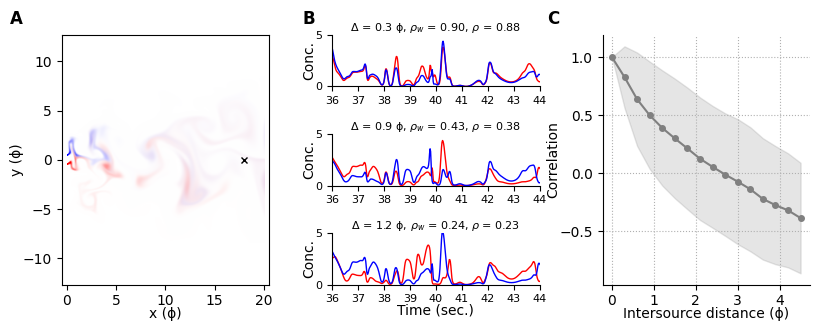

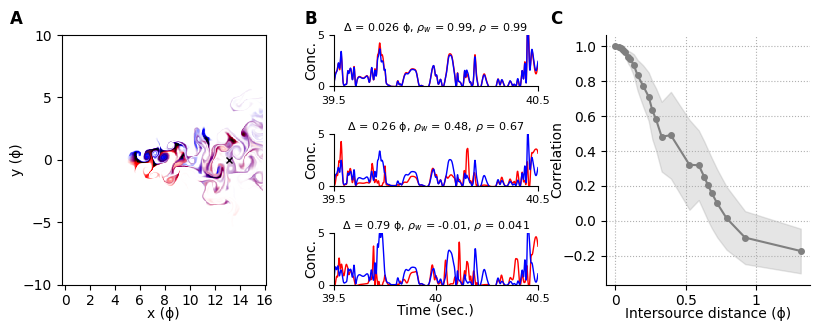

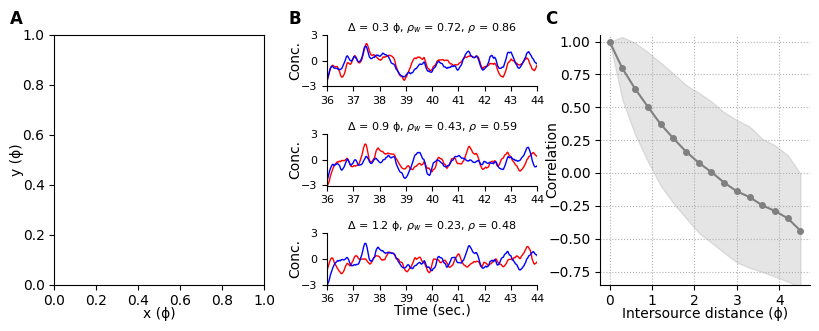

In [20]:
reload(fpf)
reload(fpft)

for k, F in sorted(data.items()):
    data_dir = os.path.join(os.environ["FISHER_PLUMES_DATA"], {"su":"", "bw":"boulder", "cr":"crick"}[k], "saved-snapshots")
    ax_plume, ax_traces, ax_corr = fpf.plot_plumes_demo(F, 40 * UNITS.sec, which_srcs[k], y_lim = (0,5.01) if k!="su" else (-3.01,3.01), y_ticks = [-3,0,3] if k=="su" else None,
                                                        t_wnd = t_wnd[k], dt = 1 * UNITS.sec, which_idists=which_idists[k], data_dir=data_dir)
    not isdefault(tticks[k]) and ax_traces[-1].set_xticks(tticks[k])    
    not isdefault(xticks[k]) and ax_plume.set_xticks(xticks[k])
    not isdefault(yticks[k]) and ax_plume.set_yticks(yticks[k])
    if k in ["su", "bw"]: ax_corr.set_xticks(arange(5))
    if k == "su": [ax_corr.set_ylim(-0.85,1.05), ax_corr.set_ylabel("Correlation",labelpad=-8)]
    fpft.label_axes([ax_plume, ax_traces[0], ax_corr], "ABC", y = [0.99]*3, fontsize=12, fontweight="bold")
    file_name = f"{fig_dir}/plumes_demo_{k}.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));    

# Set the probe index we'll use

In [21]:
iprb = 0

# Figure showing the distribution of correlations

cr
Mapped frequencies [ 1  3  7 10] Hz to indices [1, 3, 7, 10].


Wrote figs/wnd_1sec/corr_components_cr.pdf.
bw
Mapped frequencies [ 1  3  7 10] Hz to indices [1, 3, 7, 10].


Wrote figs/wnd_1sec/corr_components_bw.pdf.
su
Mapped frequencies [ 1  3  7 10] Hz to indices [1, 3, 7, 10].


Wrote figs/wnd_1sec/corr_components_su.pdf.


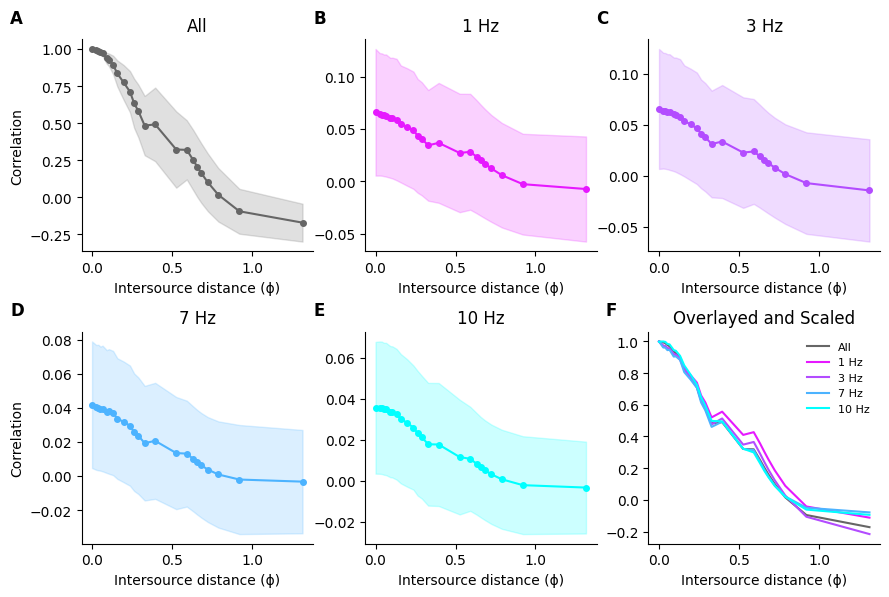

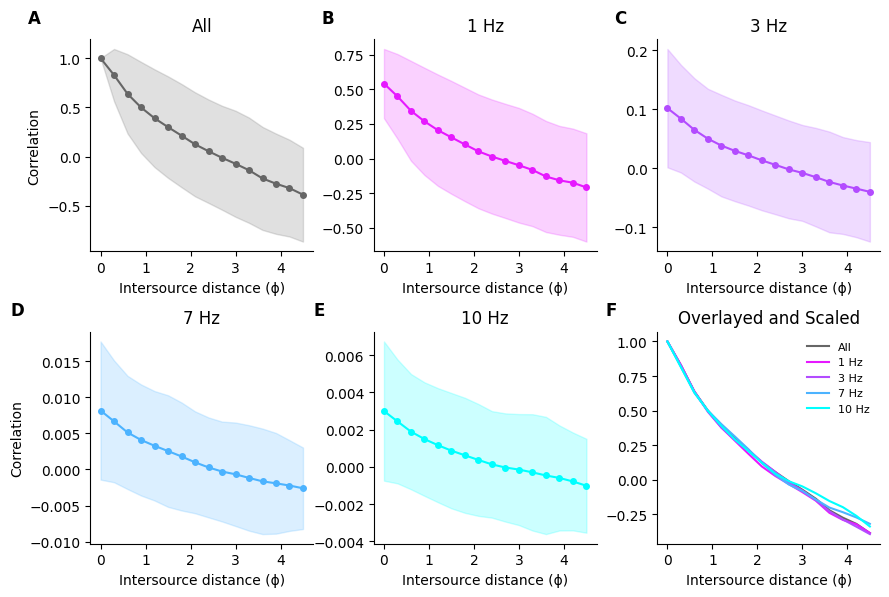

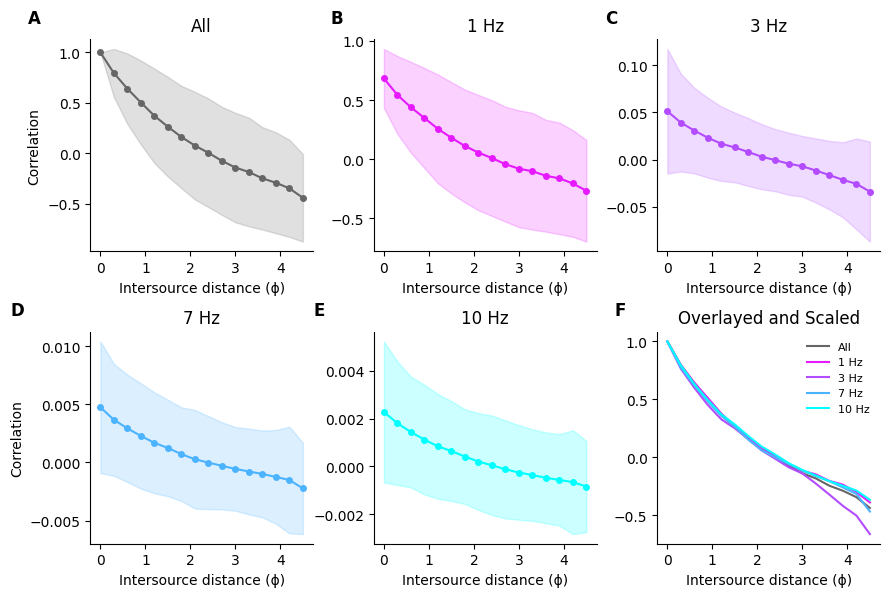

In [22]:
reload(fpf)
which_freqs = [1,3,7,10] * UNITS.hertz
labs = [f"{f}" for f in which_freqs]
cols = {"All":cm.gray(0.4)}; cols.update({l:col for l,col in zip(labs, [cm.cool(1 - f.magnitude/10) for f in which_freqs])})
xlims_  = {"su":DEFAULT, "bw":DEFAULT, "cr":DEFAULT}
xticks_ = {"su":DEFAULT, "bw":DEFAULT, "cr":DEFAULT}
for k, F in data.items():
    print(k)
    slices = {"All":slice(1,10000)}
    freq_inds = F.freqs2inds(which_freqs)
    print(f"Mapped frequencies {which_freqs} to indices {freq_inds}.")
    slices.update({l:slice(fi, fi+1) for l, fi in zip(labs, freq_inds)})
    ax = fpf.plot_correlations(F.rho[iprb], F.pitch.to("um").magnitude, slices=slices, cols=cols, n_rows = 2, plot_order = ["All"] + labs)
    [(axi.set_xlabel(f"Intersource distance ({fpf.pitch_sym})"),
      not isdefault(xlims_[k])  and axi.set_xlim(xlims_[k]),
      not isdefault(xticks_[k]) and axi.set_xticks(xticks_[k])) for axi in ax]    
    file_name = f"{fig_dir}/corr_components_{k}.pdf"
    fpft.label_axes(ax, "ABCDEF", fontsize=12, fontweight="bold", dy=-0.01)        
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."))

# The Multivariate Gaussian Fits

bw
Mapped 5 Hz to index 5.


Wrote figs/wnd_1sec/coef_vs_coef_bw_5Hz.pdf.
cr
Mapped 5 Hz to index 5.


Wrote figs/wnd_1sec/coef_vs_coef_cr_5Hz.pdf.
su
Mapped 5 Hz to index 5.


Wrote figs/wnd_1sec/coef_vs_coef_su_5Hz.pdf.


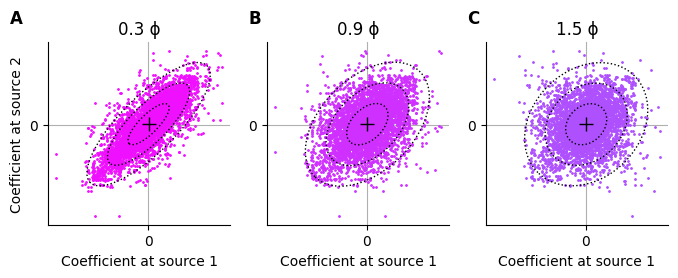

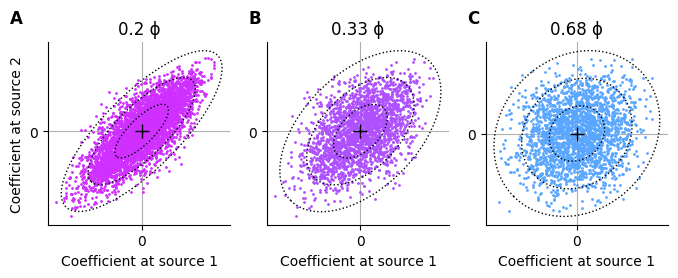

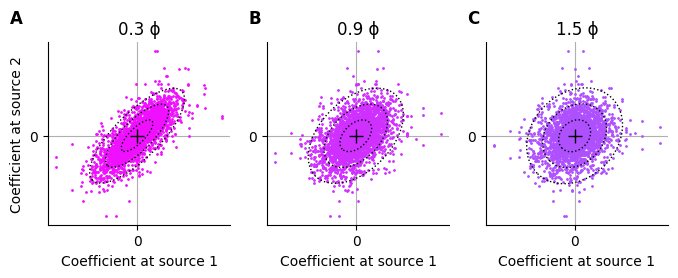

In [26]:
reload(fpf)
which_freqs = {"su":5 * UNITS.hertz,"bw":5 * UNITS.hertz, "cr":5 * UNITS.hertz}
which_idists= {"su":[0,2,4], "bw":[0,2,4], "cr":[8,12,18]}
dcol_scales = {"su":120000,  "bw":120000,  "cr":80000}
for name, F in sorted(data.items()):
    print(name)
    which_freq = which_freqs[name]
    ifreq = F.freqs2inds([which_freq])[0]
    print(f"Mapped {which_freq} to index {ifreq}.")
    ax = fpf.plot_coef1_vs_coef2([F.ss[iprb], F.cc[iprb]],
                                 ifreq,
                                 F.pairs_um,
                                 F.pitch_string,                                 
                            i_pos_dists_to_plot = which_idists[name],
                            dist_col_scale = dcol_scales[name]
    )
    fpft.label_axes(ax, "ABC", fontsize=12, fontweight="bold", dy=-0.01)            
    file_name = f"{fig_dir}/coef_vs_coef_{name}_{which_freq.magnitude}Hz.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));

# Supplementary Information

Wrote figs/wnd_1sec/coefs_and_traces_bw_5Hz.pdf.


Wrote figs/wnd_1sec/coefs_and_traces_cr_5Hz.pdf.


Wrote figs/wnd_1sec/coefs_and_traces_su_5Hz.pdf.


<Figure size 800x300 with 0 Axes>

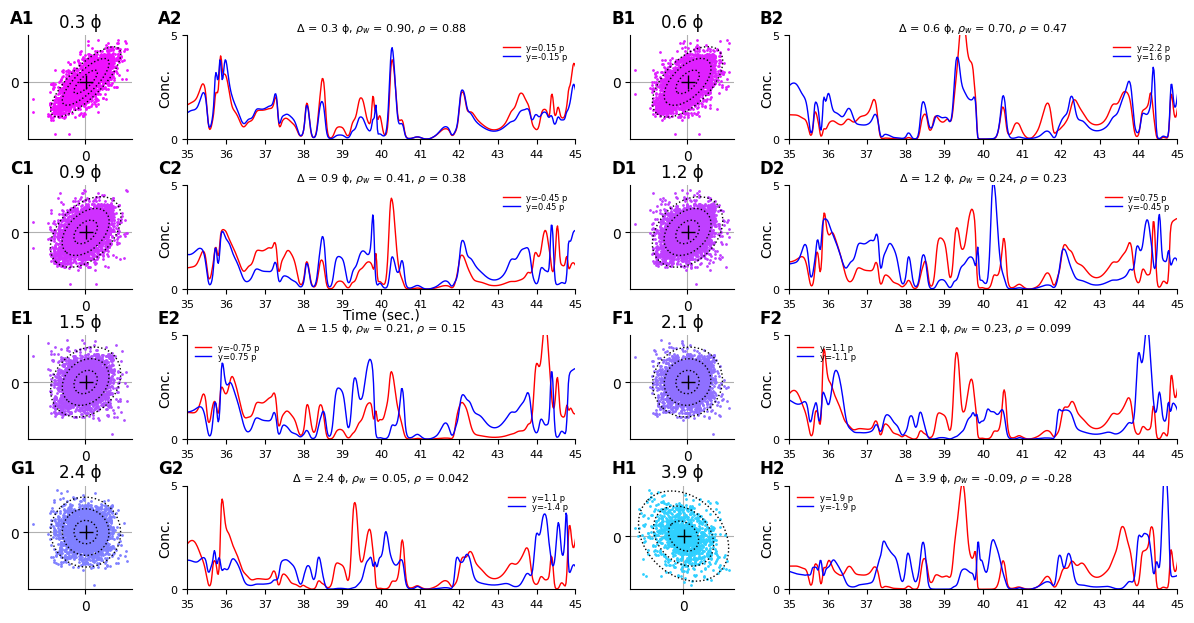

<Figure size 800x300 with 0 Axes>

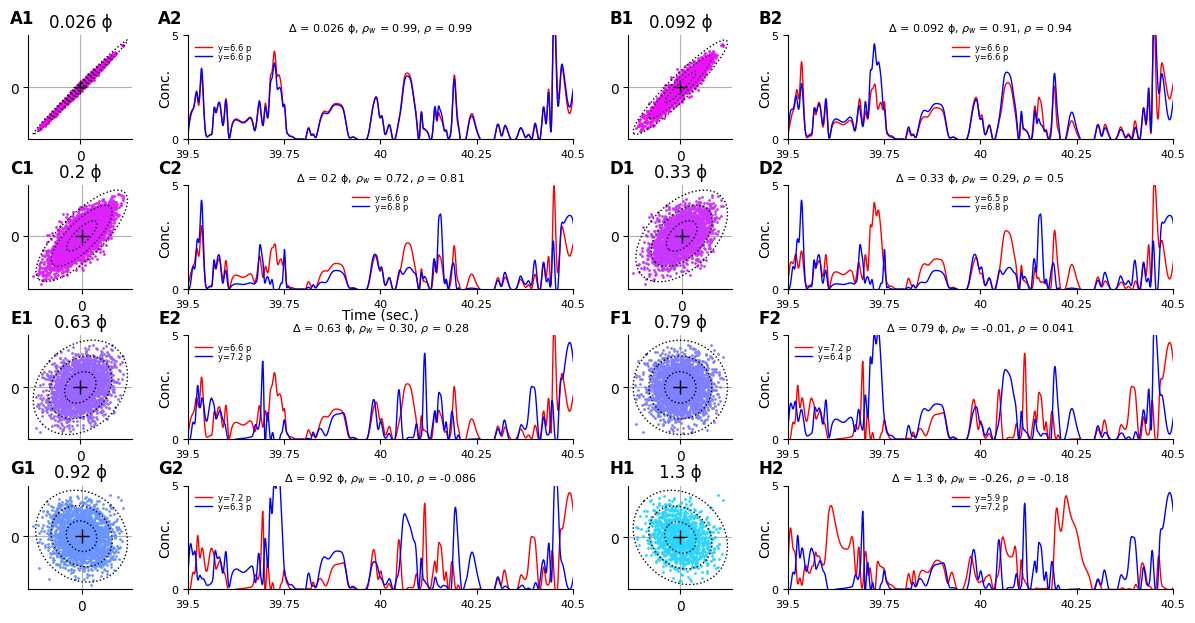

<Figure size 800x300 with 0 Axes>

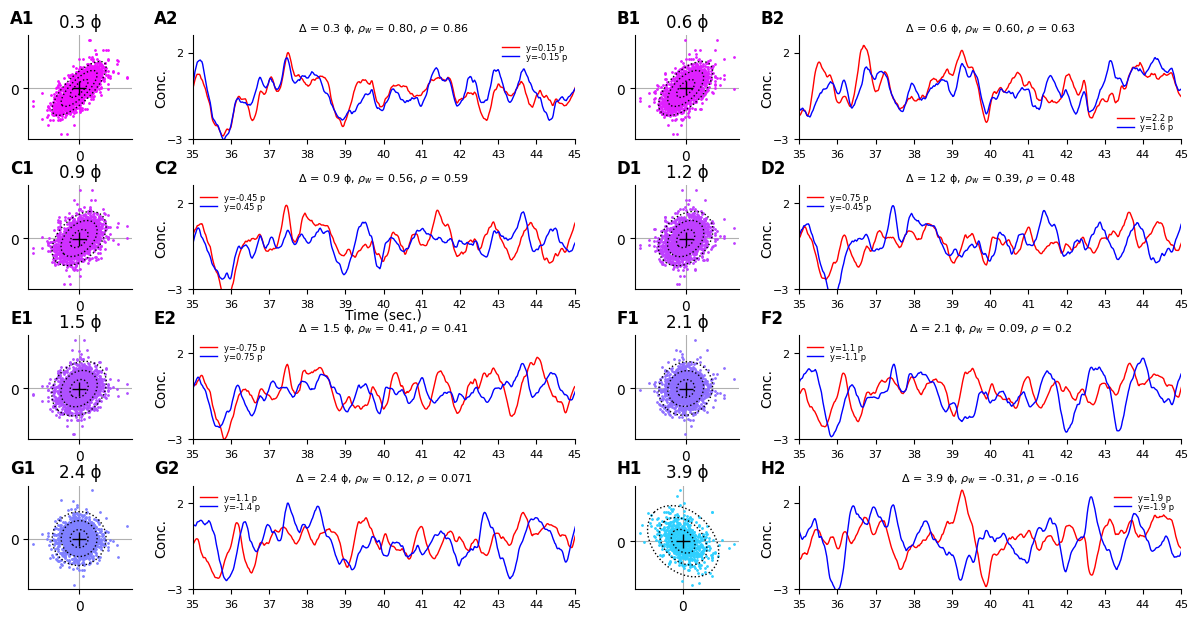

In [27]:
reload(fpf)
reload(fpft)
freq      = {"su":5 * UNITS.hertz,    "bw":5 * UNITS.hertz,          "cr":5 * UNITS.hertz}
idists    = {"su":[0,1,2,3,4,6,7,12], "bw":[0,1,2,3,4,6,7,12],       "cr":[0,4,8,12,16,20,21,22]}
t_lim     = {"su":[35, 45]*UNITS.sec, "bw":[35, 45]*UNITS.sec,       "cr":[39.5,40.5]*UNITS.sec}
dt        = {"su":1*UNITS.sec,        "bw":1*UNITS.sec,              "cr":0.25*UNITS.sec}
for k, F in sorted(data.items()):
    figure(figsize=(12,6))
    coef_ax, trace_ax = fpf.plot_coef_vs_coef_and_traces(F, freq[k], idists[k],
                                                         which_probe = iprb, n_per_row = 2,
                                                         y_lim=[0,5] if k!="su" else [-3,3],
                                                         t_lim = t_lim[k],
                                                         dt = dt[k])
    for ax in coef_ax:
        ax.set_xlabel("")
        ax.set_ylabel("")
    [ax.legend(fontsize=6,labelspacing=0,frameon=False) for ax in trace_ax]
    tight_layout(pad=0)
    all_ax = bsum([[ax_c, ax_t] for ax_c, ax_t in zip(coef_ax, trace_ax)], [])
    n_ax   = len(all_ax)
    fpft.label_axes(all_ax,
                    [ch+nu for ch in "ABCDEFGH" for nu in "12"],
                    align_x = [list(range(i,n_ax,4)) for i in range(4)],
                    align_y = [list(range(i,i+4)) for i in range(0,n_ax,4)],
                    fontsize=12, fontweight="bold", dy=-0.01)
    file_name = f"{fig_dir}/coefs_and_traces_{k}_{freq[k].to(UNITS.hertz).magnitude}Hz.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));

# Asymmetric Laplacian Fits

d=2000 @ Freq #   1: -np.log10(p) = 1.847
[0.06159792 0.00370192 0.00955331 ... 0.12384826 0.0338169  0.00923384]
d=25000 @ Freq #   1: -np.log10(p) = 0.519
[ 0.03312339 -0.00048925  0.00247277 ...  0.10534059  0.03336514
 -0.02937252]
d=52000 @ Freq #   1: -np.log10(p) = 0.429
[-0.0654824  -0.00037724 -0.01829388 ... -0.03641101 -0.04617336
 -0.00117167]
Setting extent to [-0.5, 23.5, 0.5, 100.5].


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Wrote figs/wnd_1sec/alap_fits_cr_1Hz.pdf.
d=2000 @ Freq #   5: -np.log10(p) = 2.532
[0.01949942 0.01488398 0.09620341 ... 0.03631866 0.00510159 0.03259399]
d=25000 @ Freq #   5: -np.log10(p) = 1.676
[-0.02439674 -0.02561349  0.00423021 ...  0.02775059  0.00329278
  0.03281143]
d=52000 @ Freq #   5: -np.log10(p) = 0.815
[ 0.0040602   0.00122319  0.00181387 ... -0.01264717  0.00901676
  0.04089836]


Setting extent to [-0.5, 23.5, 0.5, 100.5].


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Wrote figs/wnd_1sec/alap_fits_cr_5Hz.pdf.
d=2000 @ Freq #  10: -np.log10(p) = 2.531
[0.04987108 0.018718   0.02043595 ... 0.01107533 0.00424536 0.03464098]
d=25000 @ Freq #  10: -np.log10(p) = 1.708
[ 0.04515412  0.02218697  0.01836019 ... -0.00882384 -0.00264313
  0.02690133]
d=52000 @ Freq #  10: -np.log10(p) = 0.462
[ 0.00221804  0.01510976 -0.00881766 ... -0.0064883   0.00608274
 -0.02506879]
Setting extent to [-0.5, 23.5, 0.5, 100.5].


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Wrote figs/wnd_1sec/alap_fits_cr_10Hz.pdf.
d=7500 @ Freq #   1: -np.log10(p) = 117.111
[0.83975527 0.44638498 0.57270928 ... 0.76979393 0.53486929 0.85914464]
d=15000 @ Freq #   1: -np.log10(p) = 72.736
[ 0.82300795  0.31718915  0.63096434 ... -0.11119759  0.68824137
  0.70938795]
d=22500 @ Freq #   1: -np.log10(p) = 52.821
[ 0.62046381  0.62893909  0.68176723 ... -0.03530174  0.36959607
  0.30982411]
Setting extent to [-0.5, 15.5, 0.5, 20.5].


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Wrote figs/wnd_1sec/alap_fits_su_1Hz.pdf.
d=7500 @ Freq #   5: -np.log10(p) = 11.819
[0.0048165  0.00921298 0.03059546 ... 0.0087308  0.00015387 0.00015828]
d=15000 @ Freq #   5: -np.log10(p) = 8.456
[ 0.00677776  0.0190442  -0.00048284 ...  0.00910371  0.00123307
  0.00080148]


d=22500 @ Freq #   5: -np.log10(p) = 3.838
[1.68997781e-03 7.16557738e-04 4.49457736e-04 ... 8.94878419e-03
 5.86628035e-05 6.58186615e-03]
Setting extent to [-0.5, 15.5, 0.5, 20.5].


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Wrote figs/wnd_1sec/alap_fits_su_5Hz.pdf.
d=7500 @ Freq #  10: -np.log10(p) = 12.336
[0.00243133 0.00292565 0.004248   ... 0.00155282 0.00165557 0.00078295]
d=15000 @ Freq #  10: -np.log10(p) = 8.423
[-1.04615675e-03  7.02185003e-03 -4.33974743e-05 ...  2.02632986e-03
  1.39684943e-03  3.85317927e-04]
d=22500 @ Freq #  10: -np.log10(p) = 4.958
[-9.99495633e-05  1.08093266e-03  7.52225668e-04 ...  4.57411840e-03
 -2.25175549e-04  1.23327675e-03]
Setting extent to [-0.5, 15.5, 0.5, 20.5].


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Wrote figs/wnd_1sec/alap_fits_su_10Hz.pdf.


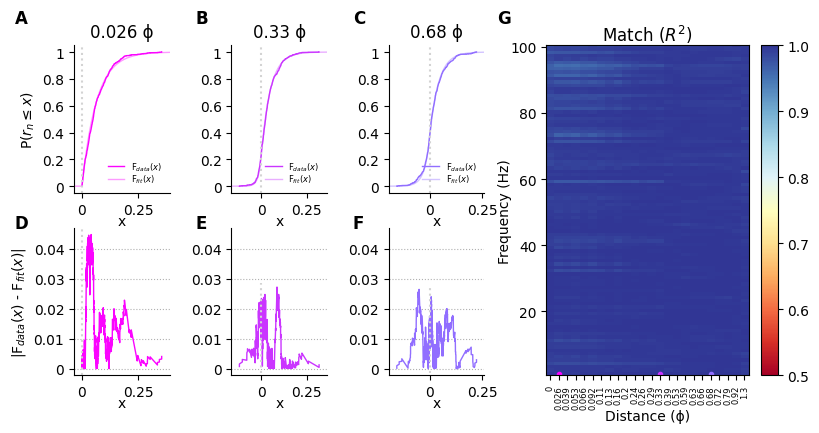

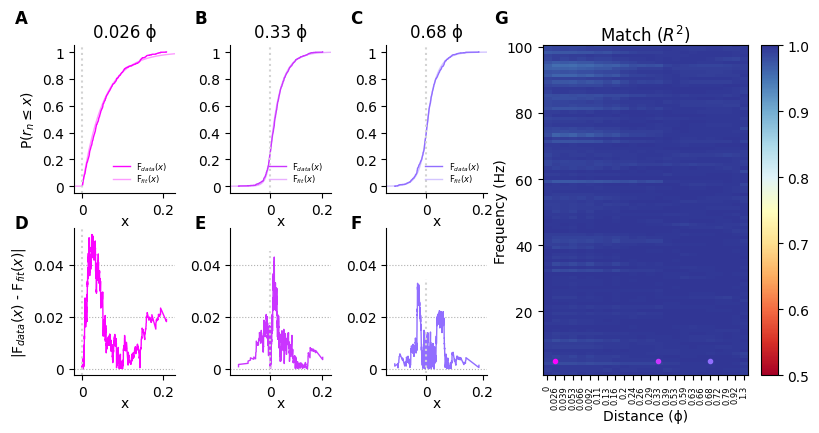

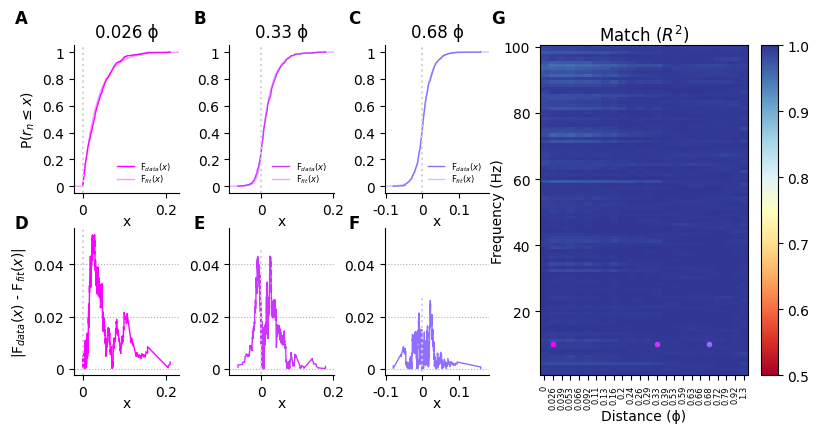

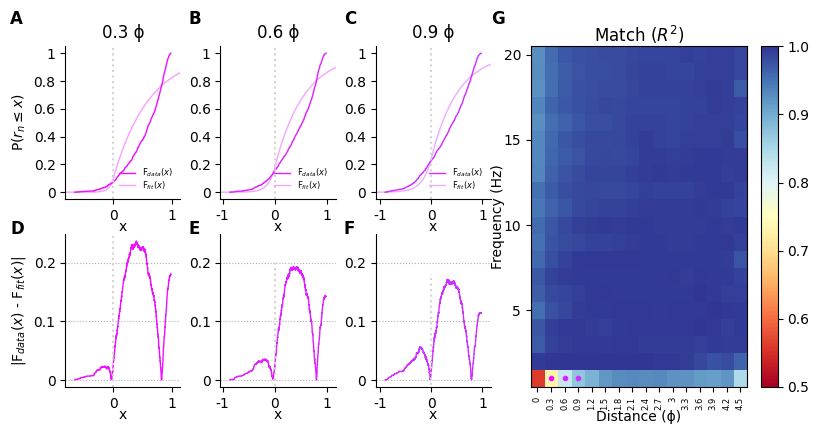

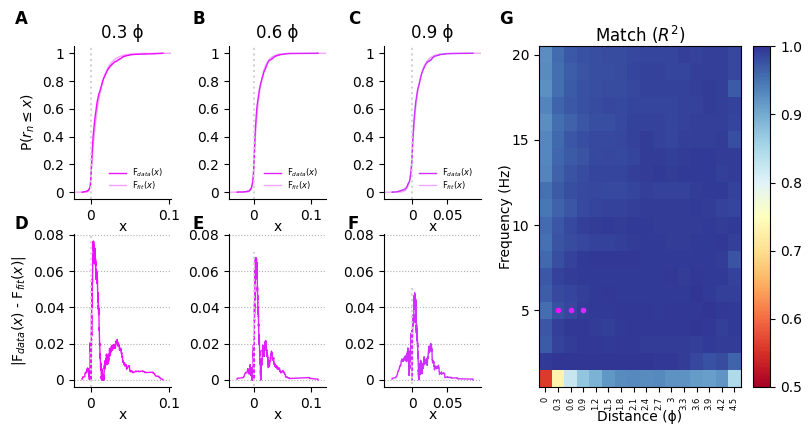

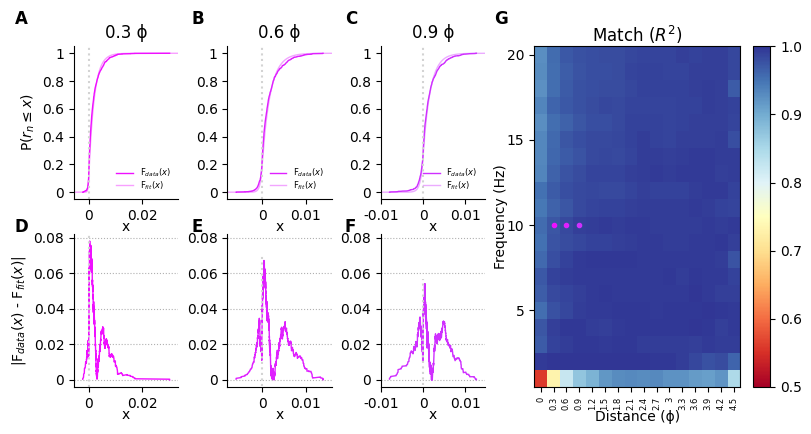

In [28]:
reload(fpft)
reload(fpf)
which_wnd_sec = wnd_sec_vals[0]
idist     = {"su":[1,2,3],          "bw":[1,2,3],       "cr":[1,13,19]}
freq_max  = {"su":21 * UNITS.hertz, "bw":21 * UNITS.hertz,            "cr":101 * UNITS.hertz}
vmin      = {"su":[0,0.5],          "bw":[0,0.5],       "cr":[0,0.5]}
vmax      = {"su":[50,1],           "bw":[50,1],        "cr":[10,1]}
plot_pvals= False
for name, F in sorted(data.items()):
    if name == "bw": continue
    d = np.array(list(F.rho[iprb].keys()))
    d = np.sort(d[d>=0])
    for f in [1, 5, 10] * UNITS.hertz:
        which_freq = {"su":f, "bw":f, "cr":f}
        ax_cdf, ax_dcdf, ax_hm = fpf.plot_alaplace_fits(F, d[idist[name]],
                                                        which_probe = iprb,
                               ifreq_lim = [1, F.freqs2inds([freq_max[name]])[0]],
                               which_ifreq = F.freqs2inds([which_freq[name]])[0],
                                                        figsize=(8,4),
                                                        vmax=vmax[name],
                                                        vmin=vmin[name],
                                                        plot_dvals=True,
                                                        plot_pvals=plot_pvals)
        tight_layout(pad=0)
        fpft.label_axes(ax_cdf + ax_dcdf + ax_hm, "ABCDEFGHIJK",
                        align_y = [[0,1,2,6],[3,4,5,7]] if plot_pvals else [[0,1,2],[3,4,5]],
                        align_x = [[0,3],[1,4],[2,5]],
                        fontsize=12, fontweight="bold", dy=0)
        file_name = f"{fig_dir}/alap_fits_{name}_{which_freq[name].to(UNITS.hertz).magnitude}Hz.pdf"
        SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));

# Plot the figure showing λ(s)

      fisher_plumes_figs 2023/05/16 08:06:34     INFO: plot_gen_exp_paramter_fits_panel with which_fis=[1, 3, 7, 10], log_scale=True.


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/colors.py:710: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  xa = np.array(X, copy=True)


Wrote figs/wnd_1sec/la_vs_s_fits_bw.pdf.


      fisher_plumes_figs 2023/05/16 08:06:35     INFO: plot_gen_exp_paramter_fits_panel with which_fis=[1, 3, 7, 10], log_scale=True.


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/colors.py:710: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  xa = np.array(X, copy=True)


      fisher_plumes_figs 2023/05/16 08:06:36     INFO: plot_gen_exp_paramter_fits_panel with which_fis=[1, 3, 7, 10], log_scale=True.


Wrote figs/wnd_1sec/la_vs_s_fits_cr.pdf.


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/colors.py:710: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  xa = np.array(X, copy=True)


Wrote figs/wnd_1sec/la_vs_s_fits_su.pdf.


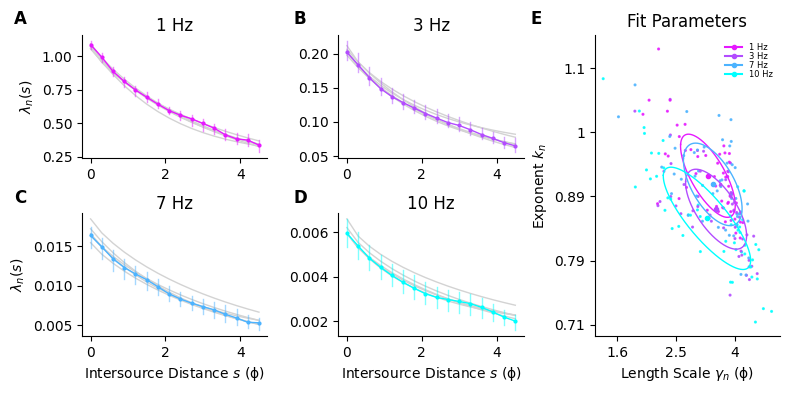

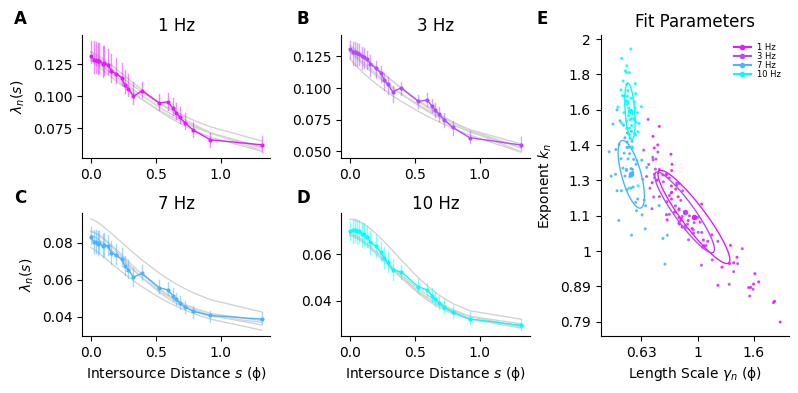

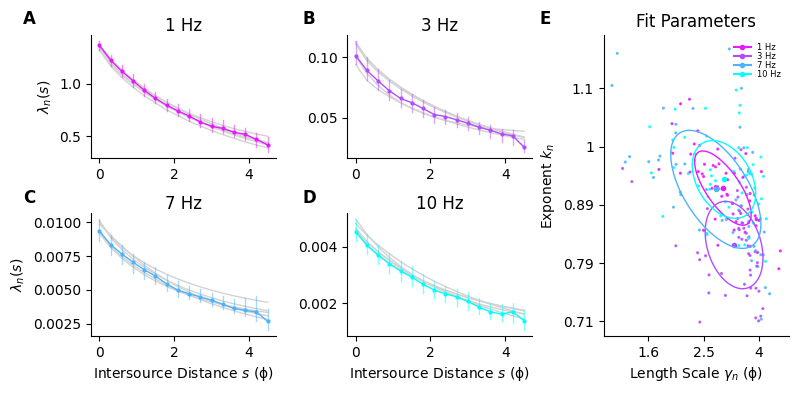

In [29]:
reload(fpft)
reload(fpf)
xl     = {"su":(-10,200),"bw":(-10,200),                 "cr": (-2, 50)}
freqs  = {"su":[1,3,7,10] * UNITS.hertz, "bw":[1,3,7,10] * UNITS.hertz,  "cr": [1,3,7,10] * UNITS.hertz}
xt     = {"su":arange(0,201,50),"bw":arange(0,201,50),          "cr": arange(0,101,25)}
xtp    = {"su":np.array([60,90,135]), "bw":np.array([60,90,135]),     "cr": np.array([40,60, 90, 135])}
ytp    = {"su":np.array([0.8,1,1.2,1.5]),"bw":np.array([0.8,1,1.2,1.5]), "cr": np.array([0.8,1,1.2,1.5,2])}
for k, F in sorted(data.items()):
    ax = fpf.plot_la_gen_fits_vs_distance(F, 
                                          figsize=(8,4), legloc = 'right',
                                          log_scale = True,
                                          scatter_size=1.5,
                                          which_ifreqs = F.freqs2inds(freqs[k]))
    [((i>1) and axi.set_xlabel(f"Intersource Distance $s$ ({fpf.pitch_sym})")) for i, axi in enumerate(ax[:4])]
    tight_layout(h_pad=1,w_pad=0.5)
    fpft.label_axes(ax, "ABCDEFGHIJK",
                    align_y = [[0,1,4],[2,3]],
                    align_x = [[0,2],[1,3]],
                    fontsize=12, fontweight="bold", dy=-0.02)                        
    file_name = f"{fig_dir}/la_vs_s_fits_{k}.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));

# Plot the Fisher Information

      fisher_plumes_figs 2023/05/16 08:44:10     INFO: dd[0]=100, dd[-1]=125000 (0.004, 5 ϕ)


      fisher_plumes_figs 2023/05/16 08:44:10     INFO: Plotting which_ifreqs=[1, 2, 5, 10, 20].


[-2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5  2.   2.5]


Wrote figs/wnd_1sec/fisher_info_bw.pdf.


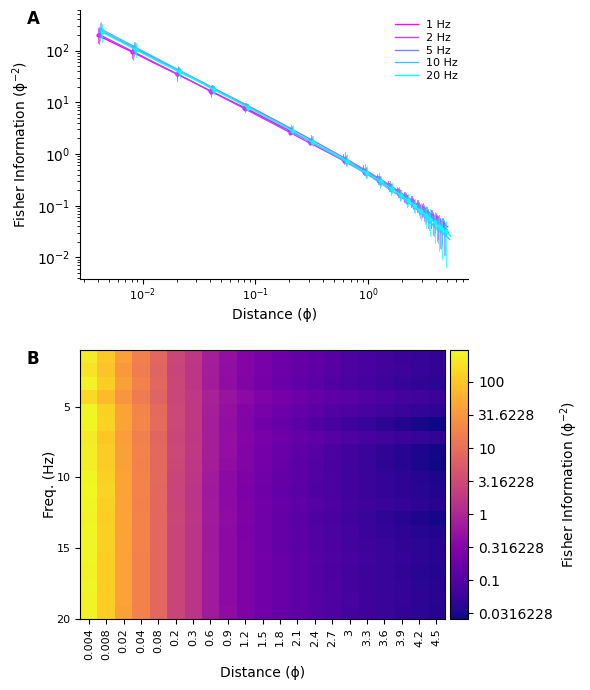

In [65]:
reload(fpt)
reload(fpft)
reload(fpf)
freqs["cr"] = [1,2, 5, 10, 20] * UNITS.hertz
freqs["bw"] = [1,2, 5, 10, 20] * UNITS.hertz
freqs["su"] = [1,2, 5, 10, 20] * UNITS.hertz
freqs["cr"] = [5,10,20,50,100] * UNITS.hertz
freq_max  = {"su":20 * UNITS.hertz,"bw":20 * UNITS.hertz, "cr":100 * UNITS.hertz}
colscale  = {"su":10, "bw":10, "cr":40}
d_vals_um = {"su":[1,5,50],"bw":[1,5,50], "cr":[0.1,10,70]}
d_lim_um  = {"su":[100, 125000], "bw":[100, 125000 ], "cr":[100, 125000]}
bf_ytick  = {"su":[0,5,10], "bw":[0,5,10], "cr":[0,50,100]}
bf_yl     = {"su":[0,15],"bw":[0,15], "cr":[-5,100]}
plot_param_fits = False
for k, F in sorted(data.items()):
    if k != "bw": continue
    figure(figsize=(6,7))
    ax_fisher, ax_best_freq, ax_d = fpf.plot_fisher_information(F,
                                                                which_probe = iprb,
                                                                d_lim_um   = d_lim_um[k],
                                                                d_vals_um  = np.array(d_vals_um[k])*1000,
                                                                d_space_fun  = lambda d0,d1,n:np.logspace(log10(d0),log10(d1),n),
                                                                which_ifreqs = F.freqs2inds(freqs[k]),
                                                                x_stagger = lambda x, i: x*(1.02**i),
                                                                fi_scale  = 1, plot_fun = plt.loglog,
                                                                log_scale = True,
                                                                plot_param_fits = plot_param_fits,
                                                                freq_max  = freq_max[k],
                                                                colfun    = lambda f: cm.cool_r(f/colscale[k]),
                                                                info_heatmap = True,
                                                                #bf_ytick  = bf_ytick[k],
    )
    tight_layout(h_pad=2,w_pad=0)
    fpft.label_axes([ax_fisher, ax_best_freq] + ax_d , "ABCDEFGHIJK",
                    #align_y = [[2,3,4]],
                    align_x = [[0,1,2] if plot_param_fits else [0,1]],
                    fontsize=12, fontweight="bold", dy=-0.02)
    #ax_best_freq.set_ylim(bf_yl[k])
    file_name = f"{fig_dir}/fisher_info_{k}.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    

# Plot best frequency for each probe

/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Wrote figs/wnd_1sec/best_freq_bw.pdf.


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Wrote figs/wnd_1sec/best_freq_cr.pdf.


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Wrote figs/wnd_1sec/best_freq_su.pdf.


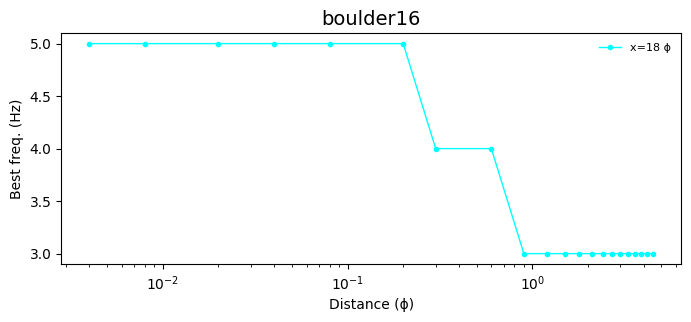

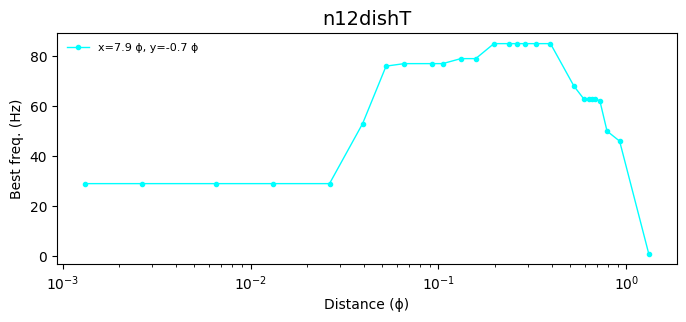

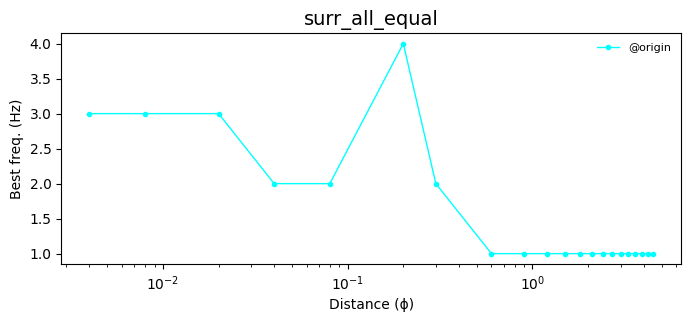

In [39]:
for k, F in sorted(data.items()):
    probe_coords = utils.d1(F.sims).get_used_probe_coords()
    probe_xcoords_sorted = sorted([p[0] for p in probe_coords])
    probe_names = utils.d1(F.sims).coord_strs
    n_probes = len(probe_coords)
    figure(figsize=(8,3))
    dd = F.I_dists/F.pitch.to(UNITS.um).magnitude
    for which_probe, (px,py) in enumerate(probe_coords):
        semilogx(dd, median(F.freqs[F.I_best_ifreqs[which_probe]][1:],axis=0),
                 "o-",markersize=3, linewidth=1, color = cm.cool(probe_xcoords_sorted.index(px)/max((n_probes-1),1)), label=probe_names[which_probe])
    xlabel("Distance (ϕ)")
    ylabel("Best freq. (Hz)")
    title(F.name, fontsize=14)
    legend(frameon=False, labelspacing=0, fontsize=8)
    file_name = f"{fig_dir}/best_freq_{k}.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
        


# Plot the Power in each Signal

Wrote figs/wnd_1sec/spectra.pdf.


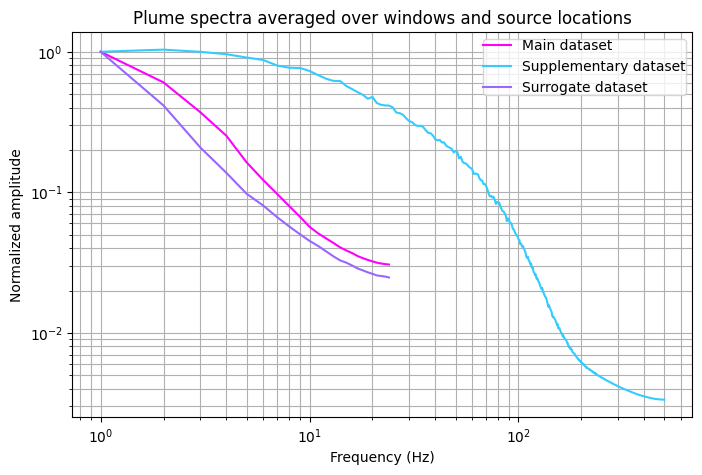

In [40]:
figure(figsize=(8,5))
for k, F in sorted(data.items()):
    f = []
    for _, s in F.sims.items():
        fs = F.fs.to(UNITS.hertz).magnitude
        fr, ti, S = stft(s.data[:,iprb], fs = fs, window='boxcar',
                         nperseg=int(fs), noverlap=fs//2, boundary=None, padded=False)
        f.append(np.abs(S))
        
    f = np.array(f)
    a = np.mean(f,axis=-1).mean(axis=0)    
    loglog(fr[fr<fs/2][1:],a[fr<fs/2][1:]/a[1], label={"cr":"Supplementary dataset", "bw":"Main dataset", "su":"Surrogate dataset"}[k], color={"su":cm.cool_r(0.4), "bw":cm.cool_r(0.0), "cr":cm.cool_r(0.8)}[k])
legend(borderpad=0)
xlabel("Frequency (Hz)")
ylabel("Normalized amplitude")
title("Plume spectra averaged over windows and source locations")
grid(True, which='both')
file_name = f"{fig_dir}/spectra.pdf"
SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));

# The End